<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/ClassicalAdder_AmazonBraket_IonQ_qiskit_braket_provider_mkbahk_20241102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 작업순서
1. Amazon Braket 환경 설정(확인만)
2. S3 환경설정(확인만)
3. (중요) IAM을 이용한 Access Key 설정 및 권한 부여
4. 원격 작업
5. 각종 로그 보기
6. 작업 환경 정리


In [1]:
!python3 -m pip install qiskit[visualization]==1.0.2
!python3 -m pip install qiskit-braket-provider==0.4.1
!python3 -m pip install amazon-braket-sdk
#!python3 -m pip install boto3
#!python3 -m pip install botocore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 10.4 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=04a3dc8785c8acefe5c5f55f903d16c206500af27e89a44a978866868885c67b
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup

In [2]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [3]:
import os
# Set environment variables for AWS credentials
os.environ['AWS_ACCESS_KEY_ID'] = ""
os.environ['AWS_SECRET_ACCESS_KEY'] = ""
os.environ['AWS_DEFAULT_REGION'] = "us-east-1"

# You can optionally set the s3 bucket and prefix using environment variables
#os.environ['AWS_BRAKET_S3_BUCKET'] = "snuqc"
#os.environ['AWS_BRAKET_S3_PREFIX'] = "amazonbraket"

In [4]:
from qiskit_braket_provider import BraketLocalBackend

local_simulator = BraketLocalBackend()
#local_sv_simulator = BraketLocalBackend(name='braket_sv')
#local_dm_simulator = BraketLocalBackend(name='braket_dm')

In [5]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()
provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])
print(provider.backends())

[BraketBackend[Ankaa-2], BraketBackend[Aria 1], BraketBackend[Aria 2], BraketBackend[Forte 1], BraketBackend[Garnet], BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]


In [6]:
#backend = provider.get_backend("Aria 1")
#backend = provider.get_backend("Aria 2")
backend = provider.get_backend("Forte 1")

#backend= provider.get_backend("Ankaa-2")
#backend = provider.get_backend("Aspen-M-3")

#Ibackend = provider.get_backend("Garnet")

#backend = provider.get_backend("SV1")
#backend = provider.get_backend("dm1")
#backend = provider.get_backend("TN1")

In [8]:
from qiskit import QuantumCircuit

# 양자 회로 생성
qc = QuantumCircuit(5, 5)  # 5개의 양자 비트와 2개의 클래식 비트를 사용합니다.

# 입력 비트 설정 (A=1, B=1)
qc.x(0)  # A 비트를 1로 설정
qc.x(1)  # B 비트를 1로 설정
qc.barrier()

# 반-가산기 회로 구현
qc.cx(0, 3) # XOR 게이트 (A와 B의 논리합)
qc.cx(1, 3) # XOR 게이트 (A와 B의 논리합)
qc.ccx(0, 1, 4) # AND 게이트 (A와 B의 논리곱)
qc.cx(2, 3) # XOR 게이트 (A와 B의 논리합)
qc.ccx(0, 2, 4) # AND 게이트 (A와 B의 논리곱)
qc.ccx(1, 2, 4) # AND 게이트 (A와 B의 논리곱)
qc.barrier()

# 결과를 측정하여 Sum과 Carry 출력을 얻습니다.
qc.measure(0, 4)  # 큐비트를 클래식 비트 4에 매핑
qc.measure(1, 3)  # 큐비트를 클래식 비트 3에 매핑
qc.measure(2, 2)  # 보조비트를 클래식 비트 2에 매핑
qc.measure(3, 1)  # Sum(Result) 비트를 클래식 비트 1에 매핑
qc.measure(4, 0)  # Carry 비트를 클래식 비트 0에 매핑

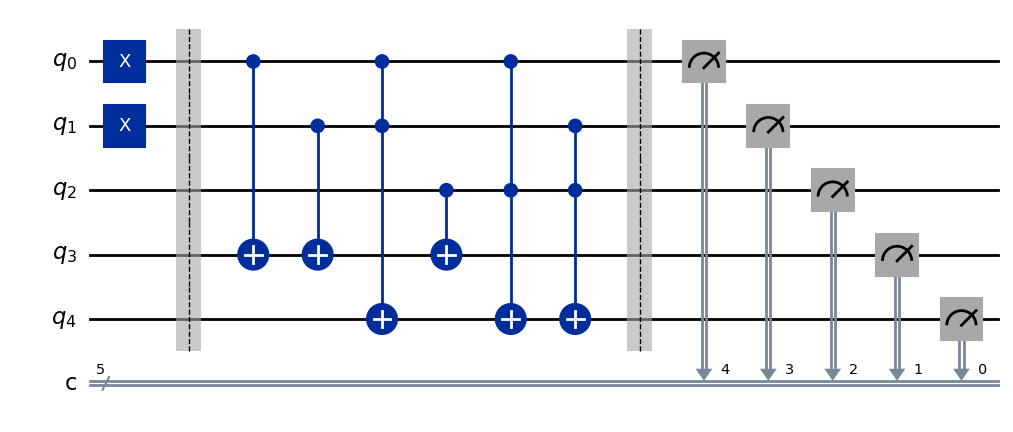

In [9]:
qc.draw("mpl")

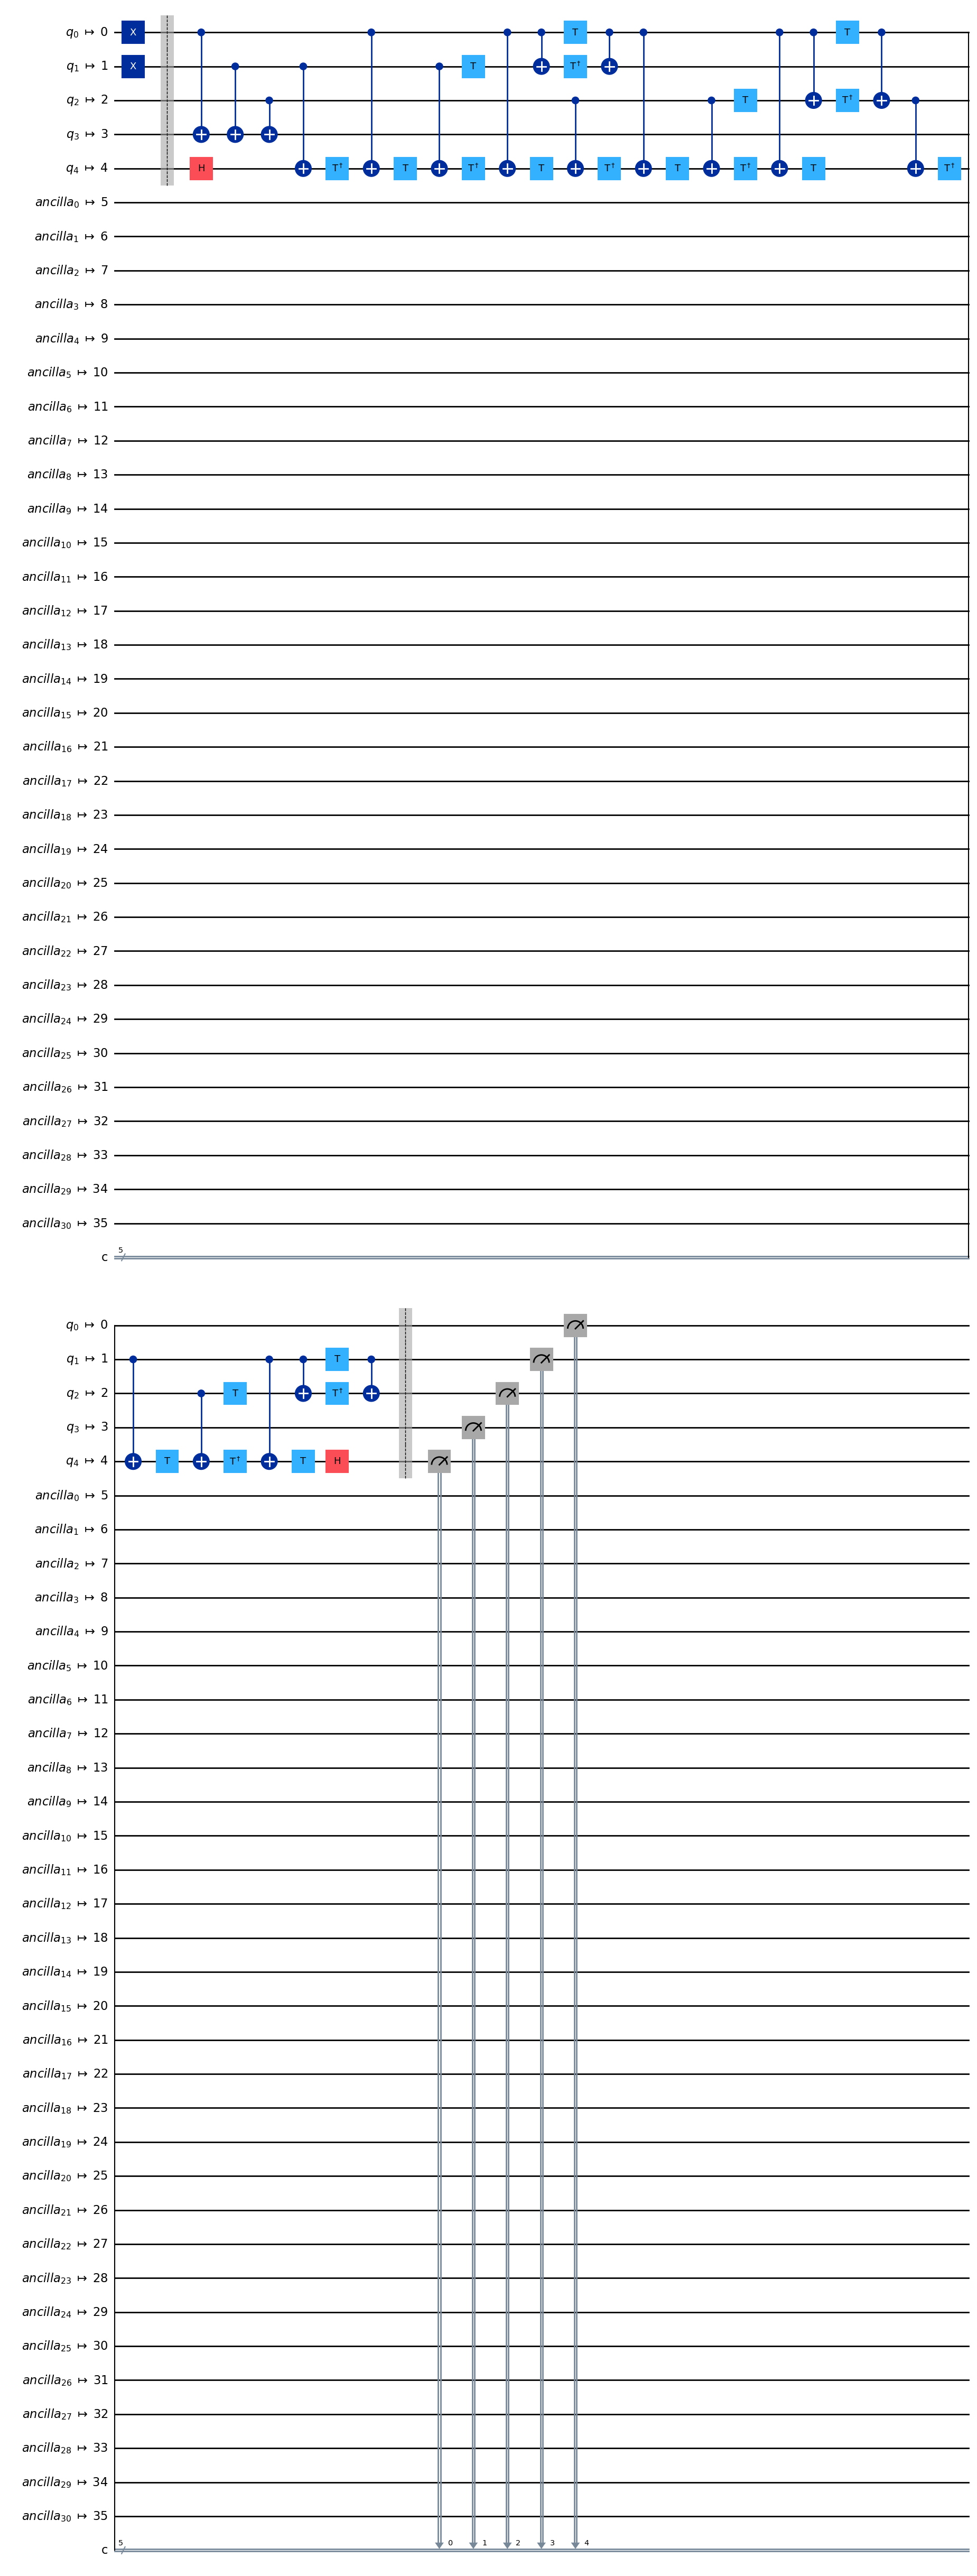

In [10]:
from qiskit.compiler import transpile, assemble
trans_qc = transpile(qc, backend)
trans_qc.draw("mpl")

In [33]:
from qiskit.providers.jobstatus import JobStatus
import time

job = backend.run(trans_qc, shots=4096)

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 지속적인 실행 상태 확인
#while job.status() is not JobStatus.DONE:
#	print("Job status is", job.status() )
#	time.sleep(2)
###while

/usr/local/lib/python3.10/dist-packages/qiskit_braket_provider/providers/adapter.py:457: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(


Job ID is arn:aws:braket:us-east-1:314146304026:quantum-task/30870b71-965b-458e-bc1c-d7ac7d20eb60 



In [59]:
print("Job status is", job.status() )

Job status is JobStatus.DONE


In [ ]:
# 중간에 세션이 종료된 경우 기존에 실행이 완료된 Job을 복구하는 방법
#job = backend.retrieve_job("arn:aws:braket:us-east-1:746669231099:quantum-task/f6fab6be-1590-4da0-914a-fade74efc485")

JobStatus.DONE


In [60]:
result = job.result()
result

Result(backend_name='BraketBackend[Forte 1]', backend_version='2', qobj_id='0', job_id='arn:aws:braket:us-east-1:314146304026:quantum-task/30870b71-965b-458e-bc1c-d7ac7d20eb60', success=True, results=[ExperimentResult(shots=4096, success=True, meas_level=2, data=ExperimentResultData(counts={'00011': 22, '10001': 38, '10010': 49, '10011': 3970, '10111': 8, '11011': 9}, memory=['00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '00011', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10001', '10010', '10010', '10010', '10010', '10010', '10010', '10010', '10010', '10010', 

In [61]:
# 결과 출력
counts = result.get_counts()
print(counts)

{'00011': 22, '10001': 38, '10010': 49, '10011': 3970, '10111': 8, '11011': 9}


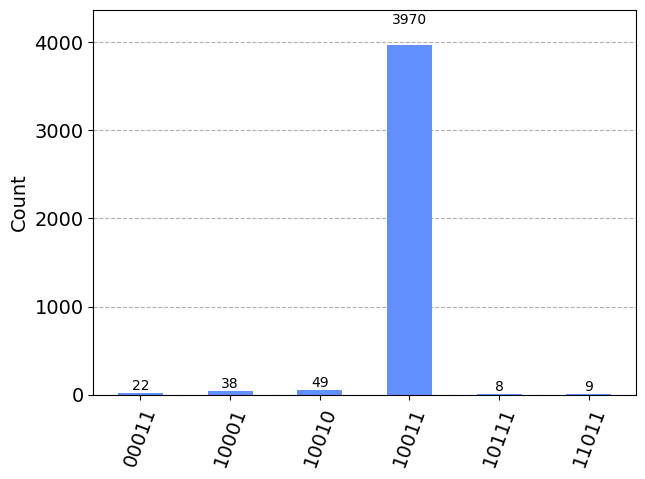

In [62]:
from qiskit.visualization import plot_histogram
plot_histogram(data=counts)

In [63]:
print("Quantum Task Summary\n")
print(t.quantum_tasks_statistics())
print('\nNote: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. \nEstimated charges shown may differ from your actual charges. \nEstimated charges do not factor in any discounts or credits, \nand you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"\nEstimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary

{'arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1': {'shots': 7168, 'tasks': {'COMPLETED': 3}}}

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. 
Estimated charges shown may differ from your actual charges. 
Estimated charges do not factor in any discounts or credits, 
and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).

Estimated cost to run this example: 574.34 USD
